### Importation des librairies utilisés dans le notebook

In [2]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols
from scipy.integrate import quad
from scipy.optimize import minimize

from math import sqrt, log, exp, pi

from scipy.stats import norm, multivariate_normal

### Creation d'une fonction de calcul de prix des options avec Black-Scholes

In [3]:
def bs(rates, spot, strike, tau, sigma, type="c"):
    d1 = (log(spot / strike) + (rates + (sigma ** 2) / 2) * tau) / (sigma * sqrt(tau))
    d2 = d1 - sigma * sqrt(tau)
    if type == "c":
        return spot * norm.cdf(d1, 0, 1) - strike * exp(-rates * tau) * norm.cdf(d2, 0, 1)
    elif type == "p":
        return strike * exp(-rates * tau) * norm.cdf(-d2, 0, 1) - spot * norm.cdf(-d1, 0, 1)



### Calibration des courbes de taux a l'aide de L'algorithme de Nelson-Siegel-Svensson

In [4]:
date = pd.Timestamp('2022-01-03')
url = f"https://home.treasury.gov/resource-center/data-chart-center/interest-rates/daily-treasury-rates.csv" \
      f"/{date.year}/all?type=daily_treasury_yield_curve&field_tdr_date_value={date.year}&page&_format=csv"
rates = pd.read_csv(url, index_col=0, parse_dates=True)
curve = rates.loc[date].dropna(axis=0) / 100

yield_maturities = []

for maturities in curve.index:
    if "Mo" in maturities:
        yield_maturities.append(int(maturities.replace(" Mo", "")) / 12)
    elif "Yr" in maturities:
        yield_maturities.append(int(maturities.replace(" Yr", "")))

yield_maturities = np.array(yield_maturities)

beta, nss_status = calibrate_nss_ols(yield_maturities, curve.to_numpy())
parameters = beta.__dict__
r = NelsonSiegelSvenssonCurve(**parameters)

### Préparation de la surface de volatilité utilisé pour la calibration du modèle

In [7]:
MAPPING_TAU = {
    "1m": 1 / 12,
    "2m": 2 / 12,
    "3m": 3 / 12,
    "6m": 6 / 12,
    "1y": 1,
    "2y": 2,
    "3y": 3,
}

vol_surface = pd.read_csv("data/sx5e_volatility_surfaces.csv",sep=";").set_index("Strike", drop=True).apply(lambda x: x / 100)

strikes = vol_surface.index.values
expiry = vol_surface.columns.values

price_surface = pd.DataFrame({}, index=strikes, columns=expiry)
vol_coordinates = vol_surface.applymap(lambda x: (np.where(vol_surface == x))).applymap(lambda x: (x[0][0], x[1][0]))
price_surface = vol_coordinates.applymap(lambda x: bs(rates=r.zero(MAPPING_TAU[expiry[x[1]]]),
                                                      spot=100,
                                                      strike=strikes[x[0]],
                                                      tau=MAPPING_TAU[expiry[x[1]]],
                                                      sigma=vol_surface.iloc[x[0], x[1]]))

### Préparation des fonctions nécessaires au calcul du prix d'un Call Européen via la formule semi-explicite de Heston

In [8]:
def heston_characteristic_function(u, spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r):
    """
    :
    :param u: complex variable
    :param spot: spot price
    :param variance: variance
    :param kappa: mean reversion speed
    :param theta: mean reversion level
    :param sigma: volatility of variance
    :param rho: correlation between spot and variance
    :param lambda_: market price risk
    :param expiry: time to maturity
    :param r: risk free rate
    :return: characteristic function of the Heston model
    """
    a = kappa * theta
    b = kappa + lambda_

    rspi = rho * sigma * u * 1j

    d = np.sqrt((rho * sigma * u * 1j - b) ** 2 + (u * 1j + u ** 2) * sigma ** 2)

    g = (b - rspi + d) / (b - rspi - d)

    exp1 = np.exp(r(expiry) * u * 1j * expiry)
    term2 = spot ** (u * 1j) * ((1 - g * np.exp(d * expiry)) / (1 - g)) ** (-2 * a / sigma ** 2)
    exp2 = np.exp(a * expiry * (b - rspi + d) / sigma ** 2 + variance * (b - rspi + d) * (
            (1 - np.exp(d * expiry)) / (1 - g * np.exp(d * expiry))) / sigma ** 2)

    return exp1 * term2 * exp2

def heston_integrand(u, K, spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r):
    """

    :param u: complex variable
    :param K: strike
    :param spot: spot price
    :param variance: variance
    :param kappa: mean reversion speed
    :param theta: mean reversion level
    :param sigma: volatility of variance
    :param rho: correlation between spot and variance
    :param lambda_: market price risk
    :param expiry: time to maturity
    :param r: risk free rate
    :return: integrand of the Heston model
    """
    args = (spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r)
    f1 = np.exp(r(expiry) * expiry) * heston_characteristic_function(u - 1j, *args) / (u * 1j * K ** (1j * u))
    f2 = K * heston_characteristic_function(u, *args) / (u * 1j * K ** (1j * u))
    return f1 - f2

def heston_price(K, spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r):
    """
    :
    :param K: strike
    :param spot: spot price
    :param variance: variance
    :param kappa: mean reversion speed
    :param theta: mean reversion level
    :param sigma: volatility of variance
    :param rho: correlation between spot and variance
    :param lambda_: market price risk
    :param expiry: time to maturity
    :param r: risk free rate
    :return: price of a call option for the Heston model
    """
    args = (K, spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r)

    real_integral, err = np.real(quad(heston_integrand, 0, 100, args=args))
    return (spot - K * np.exp(- r(expiry) * expiry)) / 2 + real_integral / np.pi

### Préparation des paramètres a optimiser a l'aide de l'algorithme d'optimisation

In [9]:
parameters = {
    "v0": {"u0": np.random.uniform(1e-3, 0.99999), "lbub": [1e-6, 0.99999]},
    "kappa": {"u0": np.random.uniform(1e-6, 4.99999), "lbub": [1e-6, 4.99999]},
    "theta": {"u0": np.random.uniform(1e-6, 0.99999), "lbub": [1e-6, 0.99999]},
    "vol_vol": {"u0": np.random.uniform(1e-6, 0.99999), "lbub": [1e-6, 0.99999]},
    "rho": {"u0": np.random.uniform(-0.99999, 0.99999), "lbub": [-0.99999, 0.99999]},
    "lambda": {"u0": np.random.uniform(-0.99999, 0.99999), "lbub": [-0.99999, 0.99999]},
}

u0 = [parameters[key]["u0"] for key, param in parameters.items()]
boundaries = [param["lbub"] for key, param in parameters.items()]


In [10]:
def cost_function(u):
    """Cost function to minimize"""
    variance, kappa, theta, sigma, rho, lambda_ = u
    heston_prices = vol_coordinates.applymap(
        lambda x: heston_price(
            K=strikes[x[0]],
            spot=100,
            variance=variance,
            kappa=kappa,
            theta=theta,
            sigma=sigma,
            rho=rho,
            lambda_=lambda_,
            expiry=MAPPING_TAU[expiry[x[1]]],
            r=r
        )
    )

    na_columns = heston_prices.columns[heston_prices.isna().any()].tolist()
    return np.sum(
        np.sum((price_surface.drop(na_columns, axis=1) - heston_prices.drop(na_columns, axis=1)) ** 2)) / (
            len(strikes) * (len(expiry) - len(na_columns)))


def constraint(u):
    """Constraint on the variance to make sure it is positive"""
    variance, kappa, theta, sigma, rho, lambda_ = u
    return - (2 * kappa * theta - sigma)


def calibrate_heston():
    """Calibrate the Heston model"""
    res = minimize(cost_function, u0, method='SLSQP', options={"maxiter": 1e4}, tol=1e-3, bounds=boundaries)
    u_star = {key: res.x[i] for i, key in enumerate(parameters.keys())}
    return u_star, res.message, res.status, res.fun

### Définition de la fonction permettant de généerer des simulations de Monte-Carlo sous la dynamique de Heston

In [11]:
def heston_montecarlo(spot, variance, kappa, theta, sigma, rho, lambda_, expiry, r, nb_steps, nb_simulations,
                      p="Q"):
    """

    :param spot: spot price
    :param variance: variance
    :param kappa: mean reversion speed
    :param theta: mean reversion level
    :param var_vol: volatility of variance
    :param rho: correlation between spot and variance
    :param lambda_: market price risk
    :param expiry: time to maturity
    :param r: risk free rate
    :param nb_steps: number of steps
    :param nb_simulations: number of simulations
    :param p: "P" for historical measure, "Q" for simulation under the risk neutral measure
    :return:
    """
    kappa_p = kappa - lambda_
    theta_p = theta * kappa / kappa_p

    xo = np.log(spot)
    vo = np.log(variance)

    dt = expiry / nb_steps

    feller = 2 * kappa > sigma
    ans = None
    if not feller:
        ans = input("Warning: Feller condition is not satisfied. Please press 'y' to continue or 'n' to stop.")
        while ans not in ["y", "n"]:
            ans = input("Please press 'y' to continue or 'n' to stop.")
        if ans == "n":
            return

    mu = np.zeros(2)
    cov = np.array([[1, rho], [rho, 1]])

    W = multivariate_normal.rvs(mean=mu, cov=cov, size=(nb_simulations, nb_steps - 1))
    W_S = W[:, :, 0]
    W_V = W[:, :, 1]

    S = np.zeros((nb_simulations, nb_steps))
    V = np.zeros((nb_simulations, nb_steps))

    S[:, 0] = spot
    V[:, 0] = variance

    kappa = kappa if p == "Q" else kappa_p
    theta = theta if p == "Q" else theta_p

    for i in range(nb_steps - 1):
        S[:, i + 1] = S[:, i] * np.exp((r(expiry) - 0.5 * V[:, i]) * dt + np.sqrt(V[:, i] * dt) * W_S[:, i])
        V[:, i + 1] = V[:, i] + np.maximum(kappa * (theta - V[:, i]) * dt + sigma * np.sqrt(V[:, i] * dt) * W_V[:, i],
                                           0)

    return S, V

In [12]:
u_star, _, _, _ = calibrate_heston()
v0, kappa, theta, vol_vol, rho, lambda_ = [u for u in u_star.values()]

### Calcul de la RMSE

In [19]:
spot = 100
v0_star = 0.03934503
kappa_star = 0.127164104
theta_star = 0.055037216
vol_vol_star = 0.001980635
rho_star = -0.758753956
lambda_star = -0.070279871

S, V = heston_montecarlo(spot, v0_star, kappa_star, theta_star, vol_vol_star, rho_star, lambda_star,
                         MAPPING_TAU[expiry[5]], r, 503,
                         20000, "P")
data = yf.download(tickers="spx", start="2015-01-05", end="2016-12-31", progress=False)["Close"]
data_std = data.rolling(5).std().dropna().to_numpy()
S = pd.DataFrame(S.T).mean(axis=1)
S_std = S.rolling(5).std().dropna().to_numpy()
rmse = np.sqrt(np.sum((data_std - S_std) ** 2) / len(data_std))

In [20]:
rmse

0.00828166220212279

### Verification des faits stylisés

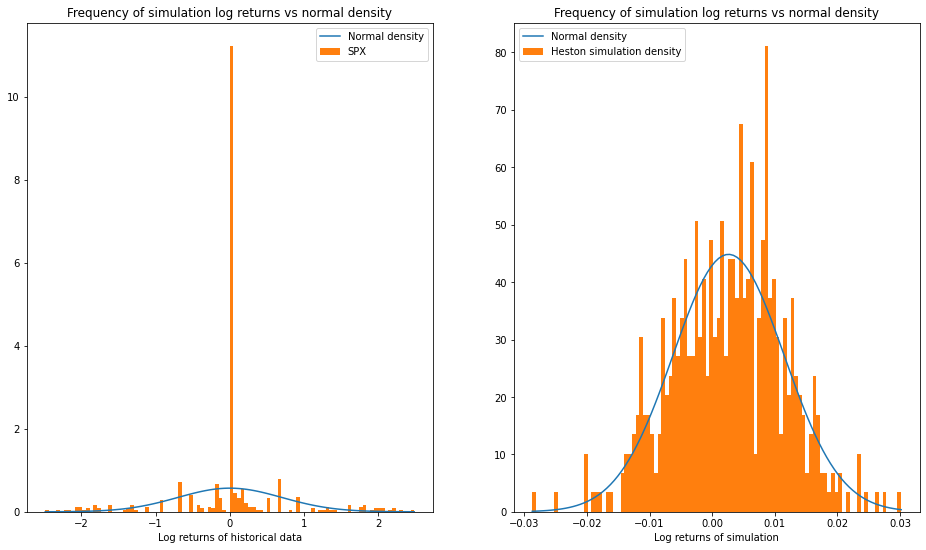

In [14]:
log_returns_data = np.log(data).diff(1).dropna()
x_data = np.linspace(log_returns_data.min(), log_returns_data.max(), 100)
log_returns_S = np.log(S).diff(1).dropna()
x_S = np.linspace(log_returns_S.min() * 100, log_returns_S.max() * 100, 100)

fig = plt.figure(figsize=(16, 9))
ax_data = fig.add_subplot(1, 2, 1)
ax_S = fig.add_subplot(1, 2, 2)

ax_data.plot(x_data, norm.pdf(x_data, loc=log_returns_data.mean(), scale=log_returns_data.std()), label="Normal density")
ax_data.hist(log_returns_data , bins=100, density=True, label="SPX")
ax_data.legend()
ax_data.set_title("Frequency of simulation log returns vs normal density")
ax_data.set_xlabel("Log returns of historical data")

ax_S.plot(x_S, norm.pdf(x_S, loc=log_returns_S.mean() * 100, scale=log_returns_S.std() * 100), label="Normal density")
ax_S.hist(log_returns_S * 100, bins=100, density=True, label="Heston simulation density")
ax_S.legend()
ax_S.set_title("Frequency of simulation log returns vs normal density")
ax_S.set_xlabel("Log returns of simulation")

plt.show()